# Reward Shaping

## 1. Imports

Importing various modules to the notebook including the local modules from the repository:
 - simulation environment,
 - the Evaluator (to evaluate stowage Plans),
 - algorithms (specially to find the inversion number)
 - pandas (for statistics)
 - matplotlib and seaborn for visualisations

In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath('../'))

from env import roroDeck
from analysis import *
from algorithms import inversionNumber as invNo
from valuation import evaluator as evm
from valuation import evaluation

import pandas as pd
import numpy as np
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

#set output path for plots
module_path = str(os.getcwd())+'\\out\\'
os.makedirs(module_path, exist_ok=True)

sns.set(style="whitegrid")
#sns.set(font_scale=1, rc={'text.usetex' : True})
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({'font.size': 12})
plt.rcParams.update({'text.color' : "black",
                     'axes.labelcolor' : "black"})
plt.tight_layout()

## 2. RewardShaping

### 2.0 Create a meshgrid

In [2]:
# This creates a set of all combinations of w in given ranges
def makeMeshGrid(w_simpleLoading,w_shifts,w_terminalSpace, w_terminalMand):
    systems = np.array(np.meshgrid(w_simpleLoading, w_shifts, w_terminalSpace, w_terminalMand)).T.reshape(-1, 4)
    
    return systems

### 2.1  Method to calculate 'degreeOfSort'

Method to determine the degree of Sort.

In [3]:
#Loop over all combinations of w
def calculateScore(systems,numberOfStowagePlans,lanes=None, rows=None):
    all_Observations = []
    system_reward = []
    for systemid in tqdm.tqdm(range(len(systems))):
        system = systems[systemid]

        cumulative_Rewards = np.zeros(numberOfStowagePlans)
        evaluations = []
        
        
        if lanes is not None and rows is not None:
            env = roroDeck.RoRoDeck(True, lanes=lanes, rows=rows)
        else:
            env = roroDeck.RoRoDeck(True)
            
            
            
        env.reward_system = system
        evaluator = evm.Evaluator(env.vehicle_data,env.grid)

        unique_cumulRewards = set()
        unique_eval = set()
        for i in range(numberOfStowagePlans):
            total_Reward = 0
            env.reset()
            done = False

            while not done:
                action = env.action_space_sample()
                observation_, reward, done, info = env.step(action)
                total_Reward += reward

            stowagePlan = env.get_stowage_plan()
            evaluation = evaluator.evaluate(stowagePlan)

            cumulative_Rewards[i] = total_Reward
            if total_Reward not in unique_cumulRewards and evaluation not in unique_eval:
                evaluations += [(total_Reward,evaluation)]


            unique_eval.add(evaluation)
            unique_cumulRewards.add(total_Reward)

        #Sort to Cumulative Reward
        evaluations.sort(key=lambda tup:tup[0])
        #Mark this Sequence
        sorted_cumul_Rewards = []
        for ix,a in enumerate(evaluations):
            sorted_cumul_Rewards += [(ix,a[0],a[1])]

        #Sort to true Evaluation
        #An ideal reward system will have a perfectly sorted marked sequence
        sorted_cumul_Rewards.sort(key=lambda tup: tup[2])

        rewardSystemEval = np.array([i[0] for i in sorted_cumul_Rewards])

        analyser = invNo.InversionNumberCalculator()

        #Calculate absolute inversion numver (not needed) and the degree of the sort
        try:
            invNumber,degree = analyser.calculate_degree_of_sort(rewardSystemEval)
        except:
            degree = -1

        obs = np.append(system,np.array(degree))

        all_Observations += [obs]
        
        df = pd.DataFrame(np.array(all_Observations))
        df = df.rename(columns={0: "Mandatory Cargo", 1: "caused Shifts in %", 2: "unused Space",
                               3: "unloaded mandatory cargo", 4: "Degree of Sort"})
        
        system_reward += (system,sorted_cumul_Rewards)
        
    return df, system_reward

In [4]:
# for reproducibility set a random seed here
np.random.seed(0)

In [5]:
range_simpleLoading = np.arange(-50, 20, 5) ##mandatory cargo TODO
range_shifts = np.arange(-50, 20, 5)
range_terminalSpace = np.arange(-50, 20, 5)
range_terminalMand = np.arange(-50, 20, 5)

systems = makeMeshGrid(range_simpleLoading,range_shifts,
                       range_terminalSpace,range_terminalMand)

#Set how many stowage plans should be evaluated for one combination of w
#(the results should be more robust if this number is higher)
numberOfStowagePlans_macro = 20

To get an overview on the structure of the resulting set of all combinations of $\vec{w}$. The first few combinations are shown (each row is one vector $\vec{w}_i$, the coloumns represent the elements of this vector i.e. $w_{ij}$)

In [6]:
df_test = pd.DataFrame(systems).head()

In [7]:
score_of_all_Combinations, all_evaluations = calculateScore(systems,numberOfStowagePlans_macro)


100%|██████████████████████████████████████████████████████████████████████████| 38416/38416 [1:03:43<00:00,  9.45it/s]


In [8]:
label_names =list(score_of_all_Combinations)

print(score_of_all_Combinations)

#score_of_all_Combinations[score_of_all_Combinations['Degree of Sort'] == 
#                          score_of_all_Combinations['Degree of Sort'].max()]
#score_of_all_Combinations.T[272]

       Mandatory Cargo  caused Shifts in %  unused Space  \
0                -50.0               -50.0         -50.0   
1                -50.0               -45.0         -50.0   
2                -50.0               -40.0         -50.0   
3                -50.0               -35.0         -50.0   
4                -50.0               -30.0         -50.0   
5                -50.0               -25.0         -50.0   
6                -50.0               -20.0         -50.0   
7                -50.0               -15.0         -50.0   
8                -50.0               -10.0         -50.0   
9                -50.0                -5.0         -50.0   
10               -50.0                 0.0         -50.0   
11               -50.0                 5.0         -50.0   
12               -50.0                10.0         -50.0   
13               -50.0                15.0         -50.0   
14               -45.0               -50.0         -50.0   
15               -45.0               -45

In [9]:
df_bestScores = score_of_all_Combinations[score_of_all_Combinations['Degree of Sort']
                                          ==score_of_all_Combinations['Degree of Sort'].max()]

q25_Loading = df_bestScores[label_names[0]].quantile(0.25)
q75_Loading = df_bestScores[label_names[0]].quantile(0.75)

q25_Shifts = df_bestScores[label_names[1]].quantile(0.25)
q75_Shifts = df_bestScores[label_names[1]].quantile(0.75)

q25_terminalSpace = df_bestScores[label_names[2]].quantile(0.25)
q75_terminalSpace = df_bestScores[label_names[2]].quantile(0.75)

q25_terminalMand = df_bestScores[label_names[3]].quantile(0.25)
q75_terminalMand = df_bestScores[label_names[3]].quantile(0.75)

print(df_bestScores)

       Mandatory Cargo  caused Shifts in %  unused Space  \
2053             -20.0                -5.0           0.0   
2067             -15.0                -5.0           0.0   
2109               0.0                -5.0           0.0   
2122               5.0               -10.0           0.0   
2123               5.0                -5.0           0.0   
2136              10.0               -10.0           0.0   
2151              15.0                -5.0           0.0   
4853               0.0                -5.0           0.0   
7583              -5.0                -5.0           0.0   
7596               0.0               -10.0           0.0   
7597               0.0                -5.0           0.0   
7611               5.0                -5.0           0.0   
10327             -5.0                -5.0           0.0   
10355              5.0                -5.0           0.0   
10369             10.0                -5.0           0.0   
13085              0.0                -5

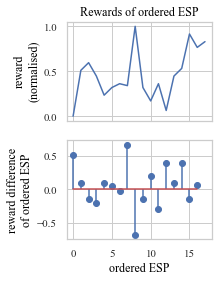

In [10]:
a = 272

rewards_semi_ordered_a = [y[1] for y in all_evaluations[a*2+1]]
rewards_semi_ordered_a = (rewards_semi_ordered_a - np.min(rewards_semi_ordered_a)) \
                        /(np.max(rewards_semi_ordered_a)-np.min(rewards_semi_ordered_a))

diff_a = np.diff(rewards_semi_ordered_a)

#figsize=(5.9, 3.5)

fig, axs = plt.subplots(2, sharex=True, figsize=(2.6, 4))
plt.setp(axs[0].get_xticklabels(), visible=True)

axs[0].plot(rewards_semi_ordered_a)
axs[0].set_title('Rewards of ordered ESP')
axs[0].set(ylabel='reward\n(normalised)')

axs[1].stem(diff_a, use_line_collection=True)
axs[1].set(xlabel='ordered ESP', ylabel='reward difference\nof ordered ESP')
axs[1].set(xlabel='ordered ESP')
fig.savefig(module_path + 'RewardSystem_a.pdf', dpi=600, bbox_inches="tight")
plt.show()


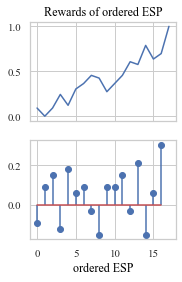

In [11]:
b = 4447

rewards_semi_ordered_b = [y[1] for y in all_evaluations[b*2+1]]
rewards_semi_ordered_b = (rewards_semi_ordered_b - np.min(rewards_semi_ordered_b)) \
                        /(np.max(rewards_semi_ordered_b)-np.min(rewards_semi_ordered_b))

diff_b = np.diff(rewards_semi_ordered_b)

fig, axs = plt.subplots(2, sharex=True, figsize=(2.6, 4))
plt.setp(axs[0].get_xticklabels(), visible=True)

axs[0].plot(rewards_semi_ordered_b)
axs[0].set_title('Rewards of ordered ESP')

axs[1].stem(diff_b, use_line_collection=True)
axs[1].set(xlabel='ordered ESP')
fig.savefig(module_path + 'RewardSystem_b.pdf', dpi=600, bbox_inches="tight")
plt.show()



<Figure size 432x288 with 0 Axes>

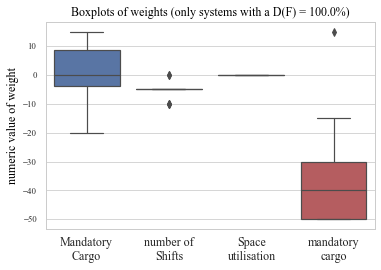

In [12]:
sns.despine(left=True)
sns.set_context("paper")
#plt.rc('text.latex', preamble=r'\usepackage[T1]{fontenc}')
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({'font.size': 11})
plt.rcParams.update({'text.color' : "black",
                     'axes.labelcolor' : "black"})

#plt.tight_layout()

#print(df_bestScores[['Loading','caused Shifts','unused Space','unloaded mandatory cargo']])

fig = plt.figure(figsize=(5.9, 3.8))


x_labels = ['Mandatory\nCargo','number of\nShifts','Space\nutilisation', 'mandatory\ncargo']

#plt.xlabel(fontsize=12)
ax = sns.boxplot(data = df_bestScores[['Mandatory Cargo','caused Shifts in %','unused Space','unloaded mandatory cargo']],
                palette="deep")


ax.set_title("Boxplots of weights (only " +
          "systems with a D(F) = {}%)".format(round(100*score_of_all_Combinations['Degree of Sort'].max()),2), fontsize=12)

plt.ylabel("numeric value of weight", fontsize=12)
ax.set_xticklabels(x_labels, fontsize=12)
#fig.autofmt_xdate()
#save locally
plt.savefig(module_path + 'Macrosearch.pdf', dpi=600, bbox_inches="tight")

plt.show()

In [81]:
range_simpleLoading = np.arange(0, 10, 1)
range_shifts = np.arange(-15, -1,1)
range_terminalSpace = np.arange(-2, 0, 1)
range_terminalMand = np.arange(-60, -25, 5)

systems_reduced = makeMeshGrid(range_simpleLoading,range_shifts,
                       range_terminalSpace,range_terminalMand)

#Set how many stowage plans should be evaluated for one combination of w
#(the results should be more robust if this number is higher)
numberOfStowagePlans = 50

In [82]:
score_of_all_Combinations_micro, _ = calculateScore(systems_reduced,numberOfStowagePlans)




  0%|                                                                                         | 0/1960 [00:00<?, ?it/s]


  0%|                                                                                 | 1/1960 [00:00<08:10,  3.99it/s]


  0%|                                                                                 | 2/1960 [00:00<07:51,  4.15it/s]


  0%|                                                                                 | 3/1960 [00:00<07:40,  4.25it/s]


  0%|▏                                                                                | 4/1960 [00:00<07:30,  4.34it/s]


  0%|▏                                                                                | 5/1960 [00:01<07:32,  4.32it/s]


  0%|▏                                                                                | 6/1960 [00:01<07:23,  4.41it/s]


  0%|▎                                                                                | 7/1960 [00:01<07:19,  4.45it/s]


  0%|▎               

  7%|█████▍                                                                         | 134/1960 [00:34<06:52,  4.43it/s]


  7%|█████▍                                                                         | 135/1960 [00:34<06:51,  4.44it/s]


  7%|█████▍                                                                         | 136/1960 [00:35<06:52,  4.42it/s]


  7%|█████▌                                                                         | 137/1960 [00:35<06:53,  4.41it/s]


  7%|█████▌                                                                         | 138/1960 [00:35<06:52,  4.42it/s]


  7%|█████▌                                                                         | 139/1960 [00:35<06:49,  4.44it/s]


  7%|█████▋                                                                         | 140/1960 [00:36<06:55,  4.38it/s]


  7%|█████▋                                                                         | 141/1960 [00:36<06:57,  4.36it/s]


  7%|█████▋             

 14%|██████████▊                                                                    | 268/1960 [01:04<06:14,  4.52it/s]


 14%|██████████▊                                                                    | 269/1960 [01:05<06:18,  4.47it/s]


 14%|██████████▉                                                                    | 270/1960 [01:05<06:18,  4.47it/s]


 14%|██████████▉                                                                    | 271/1960 [01:05<06:19,  4.45it/s]


 14%|██████████▉                                                                    | 272/1960 [01:05<06:19,  4.45it/s]


 14%|███████████                                                                    | 273/1960 [01:06<06:18,  4.46it/s]


 14%|███████████                                                                    | 274/1960 [01:06<06:18,  4.45it/s]


 14%|███████████                                                                    | 275/1960 [01:06<06:15,  4.49it/s]


 14%|███████████        

 21%|████████████████▏                                                              | 402/1960 [01:35<05:50,  4.44it/s]


 21%|████████████████▏                                                              | 403/1960 [01:35<05:47,  4.47it/s]


 21%|████████████████▎                                                              | 404/1960 [01:35<05:47,  4.47it/s]


 21%|████████████████▎                                                              | 405/1960 [01:35<05:54,  4.38it/s]


 21%|████████████████▎                                                              | 406/1960 [01:35<05:52,  4.41it/s]


 21%|████████████████▍                                                              | 407/1960 [01:36<05:49,  4.44it/s]


 21%|████████████████▍                                                              | 408/1960 [01:36<05:48,  4.45it/s]


 21%|████████████████▍                                                              | 409/1960 [01:36<05:48,  4.46it/s]


 21%|████████████████▌  

 27%|█████████████████████▌                                                         | 536/1960 [02:05<05:29,  4.32it/s]


 27%|█████████████████████▋                                                         | 537/1960 [02:05<05:26,  4.36it/s]


 27%|█████████████████████▋                                                         | 538/1960 [02:05<05:23,  4.39it/s]


 28%|█████████████████████▋                                                         | 539/1960 [02:06<05:23,  4.39it/s]


 28%|█████████████████████▊                                                         | 540/1960 [02:06<05:25,  4.36it/s]


 28%|█████████████████████▊                                                         | 541/1960 [02:06<05:24,  4.38it/s]


 28%|█████████████████████▊                                                         | 542/1960 [02:06<05:20,  4.42it/s]


 28%|█████████████████████▉                                                         | 543/1960 [02:06<05:18,  4.45it/s]


 28%|███████████████████

 34%|███████████████████████████                                                    | 670/1960 [02:42<07:26,  2.89it/s]


 34%|███████████████████████████                                                    | 671/1960 [02:42<07:10,  3.00it/s]


 34%|███████████████████████████                                                    | 672/1960 [02:43<07:02,  3.05it/s]


 34%|███████████████████████████▏                                                   | 673/1960 [02:43<07:00,  3.06it/s]


 34%|███████████████████████████▏                                                   | 674/1960 [02:43<06:45,  3.17it/s]


 34%|███████████████████████████▏                                                   | 675/1960 [02:44<06:38,  3.22it/s]


 34%|███████████████████████████▏                                                   | 676/1960 [02:44<06:40,  3.20it/s]


 35%|███████████████████████████▎                                                   | 677/1960 [02:44<06:44,  3.17it/s]


 35%|███████████████████

 41%|████████████████████████████████▍                                              | 804/1960 [03:20<05:30,  3.50it/s]


 41%|████████████████████████████████▍                                              | 805/1960 [03:20<05:26,  3.54it/s]


 41%|████████████████████████████████▍                                              | 806/1960 [03:20<05:29,  3.50it/s]


 41%|████████████████████████████████▌                                              | 807/1960 [03:21<05:28,  3.51it/s]


 41%|████████████████████████████████▌                                              | 808/1960 [03:21<05:34,  3.45it/s]


 41%|████████████████████████████████▌                                              | 809/1960 [03:21<05:21,  3.58it/s]


 41%|████████████████████████████████▋                                              | 810/1960 [03:22<05:18,  3.62it/s]


 41%|████████████████████████████████▋                                              | 811/1960 [03:22<05:20,  3.58it/s]


 41%|███████████████████

 48%|█████████████████████████████████████▊                                         | 938/1960 [03:57<04:31,  3.77it/s]


 48%|█████████████████████████████████████▊                                         | 939/1960 [03:57<04:31,  3.76it/s]


 48%|█████████████████████████████████████▉                                         | 940/1960 [03:58<04:35,  3.71it/s]


 48%|█████████████████████████████████████▉                                         | 941/1960 [03:58<04:35,  3.69it/s]


 48%|█████████████████████████████████████▉                                         | 942/1960 [03:58<04:33,  3.72it/s]


 48%|██████████████████████████████████████                                         | 943/1960 [03:59<04:30,  3.76it/s]


 48%|██████████████████████████████████████                                         | 944/1960 [03:59<04:31,  3.74it/s]


 48%|██████████████████████████████████████                                         | 945/1960 [03:59<04:28,  3.77it/s]


 48%|███████████████████

 55%|██████████████████████████████████████████▋                                   | 1072/1960 [04:34<04:01,  3.68it/s]


 55%|██████████████████████████████████████████▋                                   | 1073/1960 [04:34<04:00,  3.69it/s]


 55%|██████████████████████████████████████████▋                                   | 1074/1960 [04:35<04:00,  3.69it/s]


 55%|██████████████████████████████████████████▊                                   | 1075/1960 [04:35<04:01,  3.67it/s]


 55%|██████████████████████████████████████████▊                                   | 1076/1960 [04:35<04:02,  3.64it/s]


 55%|██████████████████████████████████████████▊                                   | 1077/1960 [04:36<04:00,  3.68it/s]


 55%|██████████████████████████████████████████▉                                   | 1078/1960 [04:36<03:59,  3.68it/s]


 55%|██████████████████████████████████████████▉                                   | 1079/1960 [04:36<04:03,  3.62it/s]


 55%|███████████████████

 62%|███████████████████████████████████████████████▉                              | 1206/1960 [05:14<03:25,  3.67it/s]


 62%|████████████████████████████████████████████████                              | 1207/1960 [05:14<03:27,  3.62it/s]


 62%|████████████████████████████████████████████████                              | 1208/1960 [05:15<03:26,  3.64it/s]


 62%|████████████████████████████████████████████████                              | 1209/1960 [05:15<03:25,  3.66it/s]


 62%|████████████████████████████████████████████████▏                             | 1210/1960 [05:15<03:27,  3.61it/s]


 62%|████████████████████████████████████████████████▏                             | 1211/1960 [05:15<03:28,  3.59it/s]


 62%|████████████████████████████████████████████████▏                             | 1212/1960 [05:16<03:30,  3.56it/s]


 62%|████████████████████████████████████████████████▎                             | 1213/1960 [05:16<03:27,  3.61it/s]


 62%|███████████████████

 68%|█████████████████████████████████████████████████████▎                        | 1340/1960 [05:55<03:08,  3.30it/s]


 68%|█████████████████████████████████████████████████████▎                        | 1341/1960 [05:55<03:06,  3.33it/s]


 68%|█████████████████████████████████████████████████████▍                        | 1342/1960 [05:56<03:03,  3.36it/s]


 69%|█████████████████████████████████████████████████████▍                        | 1343/1960 [05:56<02:59,  3.43it/s]


 69%|█████████████████████████████████████████████████████▍                        | 1344/1960 [05:56<03:03,  3.35it/s]


 69%|█████████████████████████████████████████████████████▌                        | 1345/1960 [05:56<03:01,  3.39it/s]


 69%|█████████████████████████████████████████████████████▌                        | 1346/1960 [05:57<02:58,  3.43it/s]


 69%|█████████████████████████████████████████████████████▌                        | 1347/1960 [05:57<03:01,  3.38it/s]


 69%|███████████████████

 75%|██████████████████████████████████████████████████████████▋                   | 1474/1960 [06:31<01:55,  4.19it/s]


 75%|██████████████████████████████████████████████████████████▋                   | 1475/1960 [06:31<01:55,  4.21it/s]


 75%|██████████████████████████████████████████████████████████▋                   | 1476/1960 [06:32<01:55,  4.21it/s]


 75%|██████████████████████████████████████████████████████████▊                   | 1477/1960 [06:32<01:53,  4.25it/s]


 75%|██████████████████████████████████████████████████████████▊                   | 1478/1960 [06:32<01:53,  4.25it/s]


 75%|██████████████████████████████████████████████████████████▊                   | 1479/1960 [06:32<01:54,  4.22it/s]


 76%|██████████████████████████████████████████████████████████▉                   | 1480/1960 [06:32<01:54,  4.19it/s]


 76%|██████████████████████████████████████████████████████████▉                   | 1481/1960 [06:33<01:54,  4.19it/s]


 76%|███████████████████

 82%|███████████████████████████████████████████████████████████████▉              | 1608/1960 [07:03<01:40,  3.49it/s]


 82%|████████████████████████████████████████████████████████████████              | 1609/1960 [07:03<01:40,  3.50it/s]


 82%|████████████████████████████████████████████████████████████████              | 1610/1960 [07:04<01:41,  3.45it/s]


 82%|████████████████████████████████████████████████████████████████              | 1611/1960 [07:04<01:42,  3.39it/s]


 82%|████████████████████████████████████████████████████████████████▏             | 1612/1960 [07:04<01:56,  3.00it/s]


 82%|████████████████████████████████████████████████████████████████▏             | 1613/1960 [07:05<02:23,  2.42it/s]


 82%|████████████████████████████████████████████████████████████████▏             | 1614/1960 [07:05<02:15,  2.56it/s]


 82%|████████████████████████████████████████████████████████████████▎             | 1615/1960 [07:06<02:08,  2.70it/s]


 82%|███████████████████

 89%|█████████████████████████████████████████████████████████████████████▎        | 1742/1960 [07:41<01:02,  3.47it/s]


 89%|█████████████████████████████████████████████████████████████████████▎        | 1743/1960 [07:41<01:00,  3.57it/s]


 89%|█████████████████████████████████████████████████████████████████████▍        | 1744/1960 [07:42<01:00,  3.59it/s]


 89%|█████████████████████████████████████████████████████████████████████▍        | 1745/1960 [07:42<00:59,  3.63it/s]


 89%|█████████████████████████████████████████████████████████████████████▍        | 1746/1960 [07:42<00:58,  3.66it/s]


 89%|█████████████████████████████████████████████████████████████████████▌        | 1747/1960 [07:42<00:58,  3.67it/s]


 89%|█████████████████████████████████████████████████████████████████████▌        | 1748/1960 [07:43<00:57,  3.68it/s]


 89%|█████████████████████████████████████████████████████████████████████▌        | 1749/1960 [07:43<00:56,  3.72it/s]


 89%|███████████████████

 96%|██████████████████████████████████████████████████████████████████████████▋   | 1876/1960 [08:20<00:25,  3.33it/s]


 96%|██████████████████████████████████████████████████████████████████████████▋   | 1877/1960 [08:20<00:25,  3.31it/s]


 96%|██████████████████████████████████████████████████████████████████████████▋   | 1878/1960 [08:20<00:24,  3.30it/s]


 96%|██████████████████████████████████████████████████████████████████████████▊   | 1879/1960 [08:21<00:23,  3.39it/s]


 96%|██████████████████████████████████████████████████████████████████████████▊   | 1880/1960 [08:21<00:23,  3.46it/s]


 96%|██████████████████████████████████████████████████████████████████████████▊   | 1881/1960 [08:21<00:22,  3.48it/s]


 96%|██████████████████████████████████████████████████████████████████████████▉   | 1882/1960 [08:21<00:22,  3.49it/s]


 96%|██████████████████████████████████████████████████████████████████████████▉   | 1883/1960 [08:22<00:22,  3.49it/s]


 96%|███████████████████

In [17]:
#TODO delete [0]
score_of_all_Combinations_micro

df2_bestScores = score_of_all_Combinations_micro[score_of_all_Combinations_micro['Degree of Sort']
                                          ==score_of_all_Combinations_micro['Degree of Sort'].max()]

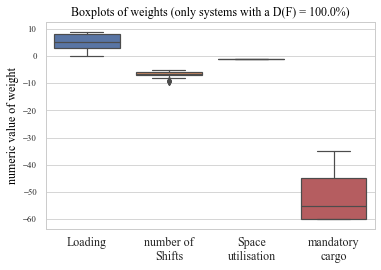

In [18]:
fig = plt.figure(figsize=(5.9, 3.8))


x_labels = ['Loading','number of\nShifts','Space\nutilisation', 'mandatory\ncargo']

#plt.xlabel(fontsize=12)
ax = sns.boxplot(data = df2_bestScores[['Mandatory Cargo','caused Shifts in %','unused Space','unloaded mandatory cargo']],
                palette="deep")


ax.set_title("Boxplots of weights (only " +
          "systems with a D(F) = {}%)".format(round(100*score_of_all_Combinations['Degree of Sort'].max()),2), fontsize=12)

plt.ylabel("numeric value of weight", fontsize=12)
ax.set_xticklabels(x_labels, fontsize=12)
#fig.autofmt_xdate()
#save locally
plt.savefig(module_path + 'Miccrosearch.pdf', dpi=600, bbox_inches="tight")

plt.show()

In [19]:
df2_bestScores

,Mandatory Cargo,caused Shifts in %,unused Space,unloaded mandatory cargo,Degree of Sort
148,0.0,-7.0,-1.0,-60.0,1.0
149,0.0,-6.0,-1.0,-60.0,1.0
163,1.0,-6.0,-1.0,-60.0,1.0
174,2.0,-9.0,-1.0,-60.0,1.0
175,2.0,-8.0,-1.0,-60.0,1.0
177,2.0,-6.0,-1.0,-60.0,1.0
188,3.0,-9.0,-1.0,-60.0,1.0
189,3.0,-8.0,-1.0,-60.0,1.0
191,3.0,-6.0,-1.0,-60.0,1.0
203,4.0,-8.0,-1.0,-60.0,1.0


In [64]:
#print(df2[df2['Degree of Sort']>0.999])


heater = score_of_all_Combinations_micro[score_of_all_Combinations_micro['Mandatory Cargo']==2]
heater = heater[heater['unused Space']==-1]

heater.head()

,Mandatory Cargo,caused Shifts in %,unused Space,unloaded mandatory cargo,Degree of Sort
168,2.0,-15.0,-1.0,-60.0,0.980000
169,2.0,-14.0,-1.0,-60.0,0.982116
170,2.0,-13.0,-1.0,-60.0,0.990622
171,2.0,-12.0,-1.0,-60.0,0.991342
172,2.0,-11.0,-1.0,-60.0,0.988153


In [65]:
heater = heater[['caused Shifts in %','unloaded mandatory cargo','Degree of Sort']]

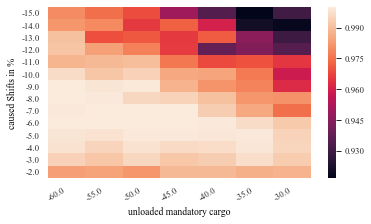

In [66]:
fig = plt.figure(figsize=(5.9, 3.5))
#plt.title("HeatMap of weights (fixed weights: Loading : 0, unused Space: -1" +
#          "systems with a D(F) {}%)".format(round(100*df2['Degree of Sort'].max()),2))
heat = heater.pivot('caused Shifts in %', 'unloaded mandatory cargo', 'Degree of Sort')
sns.heatmap(heat)

#save locally
fig.autofmt_xdate()

plt.savefig(module_path + 'HeatMap.pdf')


In [ ]:
#TODO statt heat map correlations graph

In [ ]:
#Private stuff

#score_of_all_Combinations[score_of_all_Combinations['Degree of Sort']==score_of_all_Combinations['Degree of Sort'].quantile(1)]

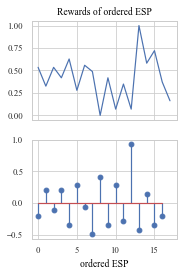

In [32]:
a = 2034
a = 853

rewards_semi_ordered_a = [y[1] for y in all_evaluations[a*2+1]]
rewards_semi_ordered_a = (rewards_semi_ordered_a - np.min(rewards_semi_ordered_a)) \
                        /(np.max(rewards_semi_ordered_a)-np.min(rewards_semi_ordered_a))

diff_a = np.diff(rewards_semi_ordered_a)

#figsize=(5.9, 3.5)

fig, axs = plt.subplots(2, sharex=True, figsize=(2.6, 4))
plt.setp(axs[0].get_xticklabels(), visible=True)

axs[0].plot(rewards_semi_ordered_a)
axs[0].set_title('Rewards of ordered ESP')
#axs[0].set(ylabel='reward\n(normalised)')

axs[1].stem(diff_a, use_line_collection=True)
#axs[1].set(xlabel='ordered ESP', ylabel='reward difference\nof ordered ESP')
axs[1].set(xlabel='ordered ESP')
fig.savefig(module_path + 'RewardSystem_b.pdf', dpi=600, bbox_inches="tight")
plt.show()


In [33]:
numberOfStowagePlans = 20
score_of_all_Combinations_micro, _ = calculateScore(np.array(df2_bestScores.drop(['Degree of Sort'], axis=1)),
                                                    numberOfStowagePlans, lanes = 12, rows=20)


 38%|███████████████████████████████                                                   | 28/74 [00:08<00:14,  3.20it/s]

KeyboardInterrupt: 

In [77]:
numberOfStowagePlans = 15

lanes_comb = [8,10,12]
rows_comb = [11,12,13,14,15,16]
env = roroDeck.RoRoDeck()
print(env.lanes)
print(env.rows)
print(np.sum(env.capacity))
score_of_all_Combinations_micro[score_of_all_Combinations_micro['Degree of Sort']==1]



8
10
60.0


,Mandatory Cargo,caused Shifts in %,unused Space,unloaded mandatory cargo,Degree of Sort
148,0.0,-7.0,-1.0,-60.0,1.0
149,0.0,-6.0,-1.0,-60.0,1.0
163,1.0,-6.0,-1.0,-60.0,1.0
174,2.0,-9.0,-1.0,-60.0,1.0
175,2.0,-8.0,-1.0,-60.0,1.0
177,2.0,-6.0,-1.0,-60.0,1.0
188,3.0,-9.0,-1.0,-60.0,1.0
189,3.0,-8.0,-1.0,-60.0,1.0
191,3.0,-6.0,-1.0,-60.0,1.0
203,4.0,-8.0,-1.0,-60.0,1.0


   Capacity
0     100.0 10 12





  0%|                                                                                            | 0/1 [00:00<?, ?it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.89it/s]C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


   Capacity
0     120.0 10 14





  0%|                                                                                            | 0/1 [00:00<?, ?it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.82it/s]

   Capacity
0     140.0 10 16





  0%|                                                                                            | 0/1 [00:00<?, ?it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.01it/s]

   Capacity
0     180.0 10 20





  0%|                                                                                            | 0/1 [00:00<?, ?it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.81it/s]

   Capacity
0     220.0 10 24





  0%|                                                                                            | 0/1 [00:00<?, ?it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.43it/s]

   Capacity
0     148.0 12 14





  0%|                                                                                            | 0/1 [00:00<?, ?it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.30it/s]

   Capacity
0     172.0 12 16





  0%|                                                                                            | 0/1 [00:00<?, ?it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.58it/s]

   Capacity
0     204.0 14 16





  0%|                                                                                            | 0/1 [00:00<?, ?it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.18it/s]

   Capacity
0     260.0 14 20





  0%|                                                                                            | 0/1 [00:00<?, ?it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.03it/s]

   Capacity
0     316.0 14 24





  0%|                                                                                            | 0/1 [00:00<?, ?it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.47it/s]

   Capacity
0     300.0 16 20





  0%|                                                                                            | 0/1 [00:00<?, ?it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.54it/s]

   Capacity
0     364.0 16 24





  0%|                                                                                            | 0/1 [00:00<?, ?it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.97it/s]

   Capacity
0     100.0 10 12





  0%|                                                                                            | 0/1 [00:00<?, ?it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.28it/s]

   Capacity
0     120.0 10 14





  0%|                                                                                            | 0/1 [00:00<?, ?it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.15it/s]

   Capacity
0     140.0 10 16





  0%|                                                                                            | 0/1 [00:00<?, ?it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.06it/s]

   Capacity
0     180.0 10 20





  0%|                                                                                            | 0/1 [00:00<?, ?it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.67it/s]

   Capacity
0     220.0 10 24





  0%|                                                                                            | 0/1 [00:00<?, ?it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.59it/s]

   Capacity
0     148.0 12 14





  0%|                                                                                            | 0/1 [00:00<?, ?it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.06it/s]

   Capacity
0     172.0 12 16





  0%|                                                                                            | 0/1 [00:00<?, ?it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.83it/s]

   Capacity
0     204.0 14 16





  0%|                                                                                            | 0/1 [00:00<?, ?it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.03it/s]

   Capacity
0     260.0 14 20





  0%|                                                                                            | 0/1 [00:00<?, ?it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.73it/s]

   Capacity
0     316.0 14 24





  0%|                                                                                            | 0/1 [00:00<?, ?it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.74it/s]

   Capacity
0     300.0 16 20





  0%|                                                                                            | 0/1 [00:00<?, ?it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.65it/s]

   Capacity
0     364.0 16 24





  0%|                                                                                            | 0/1 [00:00<?, ?it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]

   Capacity
0     100.0 10 12





  0%|                                                                                            | 0/1 [00:00<?, ?it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.37it/s]

   Capacity
0     120.0 10 14





  0%|                                                                                            | 0/1 [00:00<?, ?it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.54it/s]

   Capacity
0     140.0 10 16





  0%|                                                                                            | 0/1 [00:00<?, ?it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.55it/s]

   Capacity
0     180.0 10 20





  0%|                                                                                            | 0/1 [00:00<?, ?it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.37it/s]

   Capacity
0     220.0 10 24





  0%|                                                                                            | 0/1 [00:00<?, ?it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.52it/s]

   Capacity
0     148.0 12 14





  0%|                                                                                            | 0/1 [00:00<?, ?it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.68it/s]

   Capacity
0     172.0 12 16





  0%|                                                                                            | 0/1 [00:00<?, ?it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.61it/s]

   Capacity
0     204.0 14 16





  0%|                                                                                            | 0/1 [00:00<?, ?it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.09it/s]

   Capacity
0     260.0 14 20





  0%|                                                                                            | 0/1 [00:00<?, ?it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.06it/s]

   Capacity
0     316.0 14 24





  0%|                                                                                            | 0/1 [00:00<?, ?it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]

   Capacity
0     300.0 16 20





  0%|                                                                                            | 0/1 [00:00<?, ?it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.29it/s]

   Capacity
0     364.0 16 24





  0%|                                                                                            | 0/1 [00:00<?, ?it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.96it/s]C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


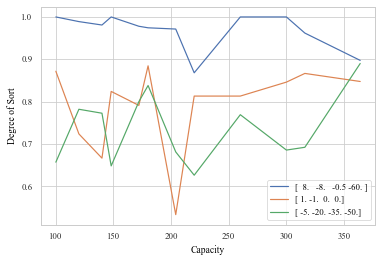

In [80]:
new_systems = np.array([[8., -8., -0.5, -60],
                        [1., -1., 0., 0.],
                        [-5., -20., -35., -50.]])
#routine to create labels
labels = []
#for system in new_systems:
#    string = '['
#    for element in system:
#        string += str(element)
#        if not element == system[-1]:
#            string += '\t'
#    string += ']'        
#    labels += [string]

#print(labels)
df_best_systems = pd.DataFrame()
ax = None

for system in new_systems:
    labels += [system]
    lanes_comb = [10,12,14,16]
    rows_comb = [12,14,16,20,24]
    df_different_sizes = pd.DataFrame(columns=label_names)
    capacities = set()
    for lane in lanes_comb:
        for row in rows_comb:
            if row > lane:
                capacity_value = np.sum(roroDeck.RoRoDeck(lanes=lane ,rows = row).capacity)
                #prevent duplicate values
                if capacity_value in capacities:
                    break
                else:
                    capacities.add(capacity_value)
                capacity = pd.DataFrame({'Capacity': [ capacity_value]})
                print(capacity, lane, row)
                a, _ = calculateScore([system], numberOfStowagePlans, lanes = lane, rows=row)
                a = a.join(capacity)
                df_different_sizes = df_different_sizes.append(a, ignore_index = True)
    if ax is None:
        ax = sns.lineplot(x='Capacity', y="Degree of Sort",
                 data=df_different_sizes)
    else:
        ax = sns.lineplot(x='Capacity', y="Degree of Sort",
                 data=df_different_sizes, ax=ax)

ax.legend(labels,loc='lower right')
plt.savefig(module_path + 'CapacityConstency.pdf', dpi=600, bbox_inches="tight")
plt.show()

In [ ]:
fig = plt.figure(figsize=(5.9, 3.5))
#plt.title("HeatMap of weights (fixed weights: Loading : 0, unused Space: -1" +
#          "systems with a D(F) {}%)".format(round(100*df2['Degree of Sort'].max()),2))
#heat = heater.pivot('caused Shifts in %', 'unloaded mandatory cargo', 'Degree of Sort')
sns.kdeplot(heater)

#save locally
fig.autofmt_xdate()

plt.savefig(module_path + 'KDE.pdf')
